##Part 2. Classifying/Predicting Using scikit-learn

 Xuyang Ji<br>Jan 31st, 2023

In [1]:
import graphviz
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import operator #for sorting 
from sklearn import preprocessing # for normalization 
from collections import Counter #finding the majority 
from sklearn.model_selection import train_test_split 
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn import neighbors, tree, naive_bayes
from sklearn.neighbors import KNeighborsClassifier
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

### I. Data Preprocessing 

In [2]:
#Preprocessing dataset
adult = pd.read_csv("/Users/xuyangji/Desktop/DSC478 ML/Assignment2/adult-modified1.csv")
adult_feature = adult.drop(["income"],axis=1)
feature= pd.get_dummies(data=adult_feature, 
                            columns=["workclass","marital-status","race","sex"])

#check all columns and coering errors if not numeric 
feature.apply(
    lambda x: pd.to_numeric(x, errors='coerce').notnull().all())

#Train-Test Split using the train test split function
target_label= adult["income"]
feature_train, feature_test,target_train, target_test = train_test_split(feature,target_label,
                                             test_size=0.2,shuffle=True)
print(feature_train.shape,feature_test.shape)

(7529, 15) (1883, 15)


### II. KNN Classifer 

#### II.a. KNN Classifer using K=10

Looking at the Running the KNN classifier using K=10, classification report and confusion matrix visualization are shown in below. The value of 0 indicates the class of _**income <=50k**_, whereas the value of 1 indicates class of _**income >50k**_. Based on precision with using the KNN classifer, out of all adults identified with income <=50k, 85% of them actually are. Based on the recall value, out of all adults actually labeled as income >50k, the model predicted correctly for only 52% of them. Finally, the value of 0.80 in f1-score indicates the model has a 80% accuracy rate, whereas the quality of classifer is much worse in predicting adult with income >50k, than predicting those with income <=50k. Finally, the model accuracy for test sets is approximately 79.8%, whereas the model accuracy for training set is approximately 94.46%. 

In [3]:
feature_train_normalized= feature_train.copy()
feature_test_normalized= feature_test.copy()

In [4]:
#Normalize data by applying Min-Max normalization techniques
for column in feature_train_normalized.columns:
    feature_train_normalized[column] = (feature_train_normalized[column] - feature_train_normalized[column].min()) / (feature_train_normalized[column].max() - feature_train_normalized[column].min())    

for column in feature_test_normalized.columns:
    feature_test_normalized[column] = (feature_test_normalized[column] - feature_test_normalized[column].min()) / (feature_test_normalized[column].max() - feature_test_normalized[column].min())    

feature_test_normalized.head()

K = 10
clf = KNeighborsClassifier(n_neighbors=K, weights='distance')
clf.fit(feature_train_normalized, target_train)
clf.score(feature_test_normalized,target_test)

##Confusion Matrix 
test_pred= clf.predict(feature_test_normalized)
con1= confusion_matrix(target_test,test_pred)
pd.crosstab(target_test, test_pred,rownames=["True"],
            colnames=["Predicted"],margins=True)


Predicted,<=50K,>50K,All
True,,,
<=50K,1249,163,1412
>50K,234,237,471
All,1483,400,1883


In [5]:
clf.score(feature_test_normalized,target_test)

0.789166224110462

In [6]:
clf.score(feature_train_normalized,target_train)

0.942887501660247

In [7]:
#Classification Report 
print(classification_report(target_test,test_pred))

              precision    recall  f1-score   support

       <=50K       0.84      0.88      0.86      1412
        >50K       0.59      0.50      0.54       471

    accuracy                           0.79      1883
   macro avg       0.72      0.69      0.70      1883
weighted avg       0.78      0.79      0.78      1883



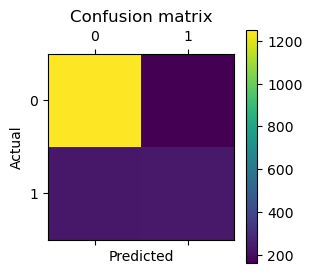

In [8]:
plt.figure(figsize=(3,3))
plt.matshow(con1,fignum=1)
plt.title('Confusion matrix')
plt.colorbar()
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

#### II.b. KNN Classifer Optimization

To improve the KNN classifer quality, models with a range of K-value from 1 to 20, and options of weight parameter are examined as below. Based on the output, _**the most optimal model accuracy is 81.5 when using uniform weighting and K=14**_. Meantime, for model using distance weighting, the most optimal model accuracy is _**80.2% with K=11**_. With using weights="distance", the model potentially overly prioritize the closest neighbor and disregard the other nearest neighbors if they are relatively further away. On the other hand, weights="uniform" ensures that even if some of the nearest neighbors are relatively further, they still count as much in prediction. 

In [9]:
#feature_train, feature_test,target_train, target_test
#Setting arrays to store accuracy for training and testing set
neighbors=np.arange(1,20)
test_accuracy_uniform= np.empty(len(neighbors))
test_accuracy_distance= np.empty(len(neighbors))

for i, K in enumerate(neighbors):
    knn= KNeighborsClassifier(n_neighbors=K, weights='distance')
    knn.fit(feature_train_normalized, target_train)
    #compute accuracy on test set 
    test_accuracy_distance[i]= knn.score(feature_test_normalized, target_test)

for i, K in enumerate(neighbors):
    knn= KNeighborsClassifier(n_neighbors=K,weights='uniform')
    knn.fit(feature_train_normalized, target_train)
    #compute accuracy on test set 
    test_accuracy_uniform[i]= knn.score(feature_test_normalized, target_test)

print(test_accuracy_uniform)
print(test_accuracy_distance)

[0.75836431 0.7700478  0.77854488 0.78810409 0.79553903 0.7928837
 0.7976633  0.80297398 0.80456718 0.80297398 0.80084971 0.80084971
 0.80669145 0.81306426 0.80881572 0.81465746 0.81518853 0.8173128
 0.81465746]
[0.75836431 0.76155072 0.77057886 0.77695167 0.78491768 0.78544875
 0.78332448 0.78863516 0.79075943 0.78916622 0.78863516 0.78332448
 0.78597982 0.78332448 0.78810409 0.78704195 0.78969729 0.78969729
 0.79129049]


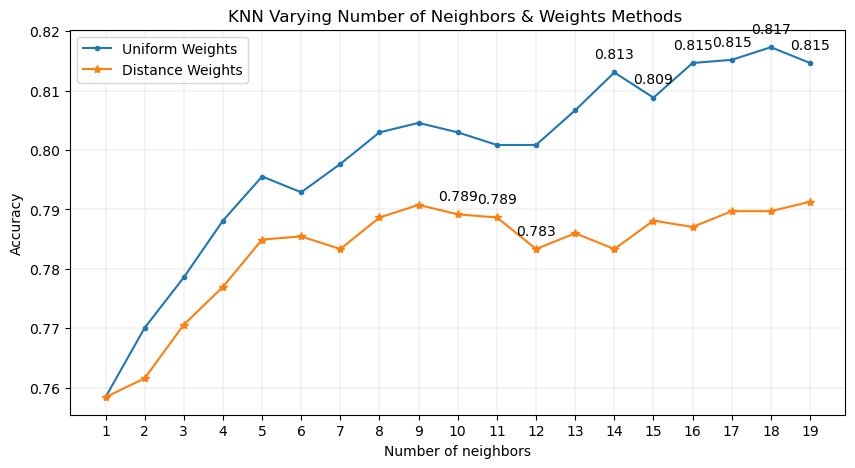

In [10]:
#Generate plot
fig, ax = plt.subplots(figsize=(10, 5))

plt.title('KNN Varying Number of Neighbors & Weights Methods ')
plt.plot(neighbors, test_accuracy_uniform, marker='.',label='Uniform Weights')
for x,y in zip(neighbors[13:],test_accuracy_uniform[13:]):
    label="{:.3f}".format(y)
    plt.annotate(label,(x,y),textcoords="offset points",xytext=(0,10),ha="center")

plt.plot(neighbors, test_accuracy_distance,marker='*', label='Distance Weights')
for x,y in zip(neighbors[9:12],test_accuracy_distance[9:12]):
    label="{:.3f}".format(y)
    plt.annotate(label,(x,y),textcoords="offset points",xytext=(0,10),ha="center")
plt.legend()
plt.xlabel('Number of neighbors')
plt.ylabel('Accuracy')
plt.xticks(np.arange(1,20))
plt.grid(color='grey', linestyle='-', linewidth=0.25, alpha=0.5)
plt.show()


#### II.c. KNN Classifer with K=14

The most optimal model accuracy is 81.5 when using uniform weighting and K=14. The accuracy of the classifer on the training and test sets are 83.25% and 81.47%, respectively. In the classification report, the value of 0 indicates the class of _**income <=50k**_, whereas the value of 1 indicates class of _**income >50k**_. Based on precision with using the KNN classifer, out of all adults identified with income <=50k, 85% of them actually are. Based on the recall value, out of all adults actually labeled as income >50k, the model predicted correctly for only 48% of them, which is worse than using k=10. Finally, the value of 0.81 in f1-score indicates the model has a 81% accuracy rate, whereas the quality of classifer is much worse in predicting adult with income >50k, than predicting those with income <=50k. 

In [11]:
K = 14
clf_14 = KNeighborsClassifier(n_neighbors=K, weights='uniform')
clf_14.fit(feature_train_normalized, target_train)
print(clf_14.score(feature_train_normalized,target_train))
print(clf_14.score(feature_test_normalized,target_test))

0.8327799176517465
0.8130642591609134


In [12]:
##Confusion Matrix 
test_pred_14= clf_14.predict(feature_test_normalized)
print(classification_report(target_test,test_pred_14))
pd.crosstab(target_test, test_pred_14,rownames=["True"],
            colnames=["Predicted"],margins=True)

              precision    recall  f1-score   support

       <=50K       0.85      0.92      0.88      1412
        >50K       0.67      0.50      0.57       471

    accuracy                           0.81      1883
   macro avg       0.76      0.71      0.73      1883
weighted avg       0.80      0.81      0.80      1883



Predicted,<=50K,>50K,All
True,,,
<=50K,1295,117,1412
>50K,235,236,471
All,1530,353,1883


#### II.d. KNN Classifer Overfitting 

Based on the plot below, overfitting is presented in classifers with k ranges from 1 to 3. The resulting models with those k_value perform poorly on the testing set, with high performance on training set, especially for model with k=1. The reason behind overfitting is that these model are trying to find patterns when there is none or too complex as trying to learn noises in the models. 

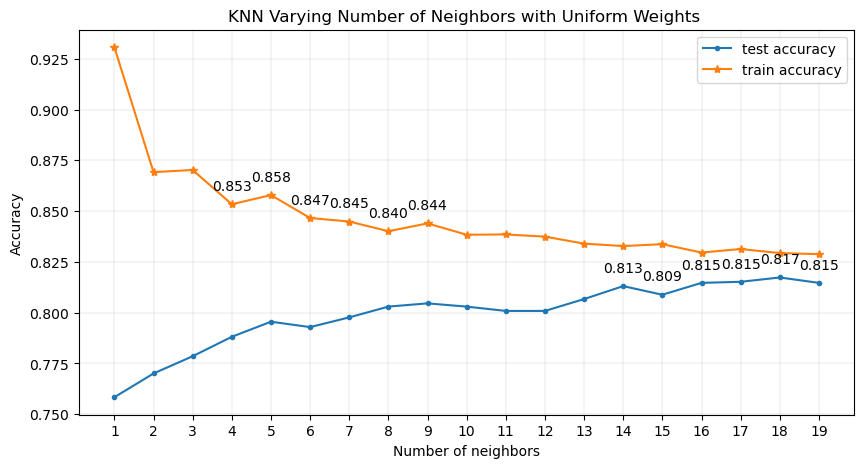

In [13]:
train_accuracy_uniform= np.empty(len(neighbors))

for i, K in enumerate(neighbors):
    knn= KNeighborsClassifier(n_neighbors=K,weights='uniform')
    knn.fit(feature_train_normalized, target_train)
    #compute accuracy on test set 
    train_accuracy_uniform[i]= knn.score(feature_train_normalized, target_train)

#Generate uniform plot
fig, ax = plt.subplots(figsize=(10, 5))

plt.title('KNN Varying Number of Neighbors with Uniform Weights ')
plt.plot(neighbors, test_accuracy_uniform, marker='.',label='test accuracy')
for x,y in zip(neighbors[13:],test_accuracy_uniform[13:]):
    label="{:.3f}".format(y)
    plt.annotate(label,(x,y),textcoords="offset points",xytext=(0,10),ha="center")

plt.plot(neighbors, train_accuracy_uniform,marker='*', label='train accuracy')
for x,y in zip(neighbors[3:9],train_accuracy_uniform[3:9]):
    label="{:.3f}".format(y)
    plt.annotate(label,(x,y),textcoords="offset points",xytext=(0,10),ha="center")
plt.legend()
plt.xlabel('Number of neighbors')
plt.ylabel('Accuracy')
plt.xticks(np.arange(1,20))
plt.grid(color='grey', linestyle='-', linewidth=0.25, alpha=0.5)
plt.show()


### III. Decision Tree Classifer

#### III.a. Using Entropy Index
The accuracy of the classifer on the training and test sets are 93.1% and 75.36%, respectively. Since the model already learned the training data, and the train error is extremely low. Hence, our data has low bias; on the other hand, a high variance. Meantime, the high variance leads to the high test error. 

In [14]:
#Perform classification using scikit-learn's decision tree classifier with default parameters
treeclf= tree.DecisionTreeClassifier(criterion='entropy', min_samples_split=3)
treeclf= treeclf.fit(feature_train, target_train)
treepreds_test= treeclf.predict(feature_test)
print(treeclf.score(feature_test,target_test))
print(treeclf.score(feature_train,target_train))
print(classification_report(target_test, treepreds_test))

0.7631439192777483
0.9292070660114224
              precision    recall  f1-score   support

       <=50K       0.83      0.87      0.85      1412
        >50K       0.53      0.45      0.49       471

    accuracy                           0.76      1883
   macro avg       0.68      0.66      0.67      1883
weighted avg       0.75      0.76      0.76      1883



In [15]:
treecm = confusion_matrix(target_test,treepreds_test)
print (treecm)
pd.crosstab(target_test, treepreds_test,rownames=["True"],colnames=["Predicted"],margins=True)

[[1226  186]
 [ 260  211]]


Predicted,<=50K,>50K,All
True,,,
<=50K,1226,186,1412
>50K,260,211,471
All,1486,397,1883


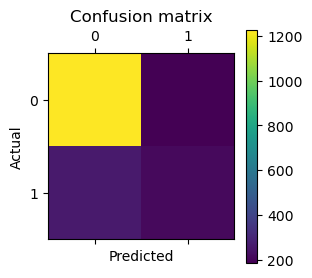

In [16]:
plt.figure(figsize=(3,3))
plt.matshow(treecm,fignum=1)
plt.title('Confusion matrix')
plt.colorbar()
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

#### III.b. Using "gini" Index 

With "gini"as the selection criteria, min_samples_split=10, and max_depth=4, the accuracy results for both the training and test sets are similar, each with 81.36% and 81.57% respectively. 

In [17]:
#Perform classification using scikit-learn's decision tree classifier with gini index parameters
treeclf_gini= tree.DecisionTreeClassifier(criterion='gini', min_samples_split=10, max_depth=4)
treeclf_gini= treeclf_gini.fit(feature_train, target_train)
treepreds_test_gini= treeclf_gini.predict(feature_test)
print(treeclf_gini.score(feature_test,target_test))
print(treeclf_gini.score(feature_train,target_train))
print(classification_report(target_test, treepreds_test_gini))

0.8125331917153479
0.8171071855492097
              precision    recall  f1-score   support

       <=50K       0.83      0.94      0.88      1412
        >50K       0.70      0.44      0.54       471

    accuracy                           0.81      1883
   macro avg       0.77      0.69      0.71      1883
weighted avg       0.80      0.81      0.80      1883



In [18]:
from sklearn.tree import export_graphviz
export_graphviz(treeclf_gini,out_file='tree_gini.dot', feature_names=feature_train.columns)

In [19]:
system(dot -Tpng tree_gini.dot -o dtree.png)

[]

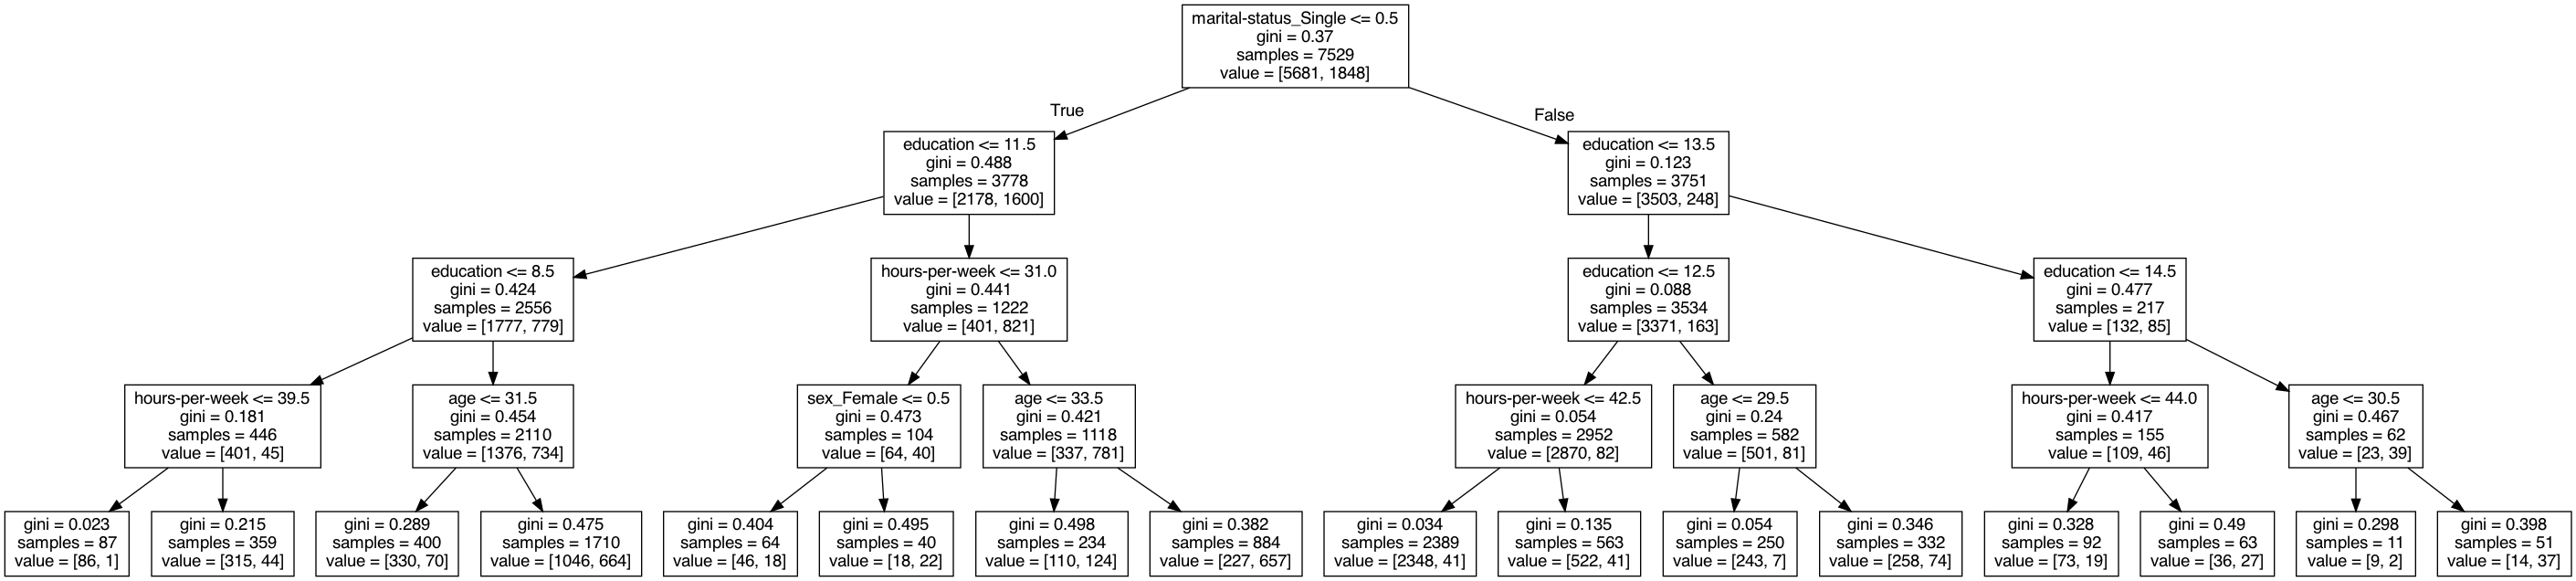

In [20]:
from IPython.display import Image
Image(filename='dtree.png', width=800)

### IV. Naive Bayes & LDA

#### IV.a. Naive Bayes

In [21]:
from sklearn import model_selection
nbclf = naive_bayes.GaussianNB()
nbclf = nbclf.fit(feature_train, target_train)
nbpreds_test = nbclf.predict(feature_test)
print (nbpreds_test)
print("Score on Training: ",nbclf.score(feature_train, target_train))
print("Score on Test: ",nbclf.score(feature_test, target_test))

cv_scores_nb = model_selection.cross_val_score(nbclf, feature_train, target_train, cv=10)
print("Overall Accuracy: %0.2f (+/- %0.2f)" % (cv_scores_nb.mean(), cv_scores_nb.std() * 2))

['>50K' '>50K' '<=50K' ... '<=50K' '>50K' '<=50K']
Score on Training:  0.7213441360074379
Score on Test:  0.7227827934147637
Overall Accuracy: 0.72 (+/- 0.04)


#### IV.b. Linear Discriminant Analysis (LDA)

In [22]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

ldclf = LinearDiscriminantAnalysis()
ldclf = ldclf.fit(feature_train, target_train)
ldpreds_test= ldclf.predict(feature_test)
print(ldpreds_test)
print ("Score on Training: ", ldclf.score(feature_train, target_train))
print ("Score on Test: ", ldclf.score(feature_test, target_test))

cv_scores_ld = model_selection.cross_val_score(ldclf, feature_train, target_train, cv=10)
print("Overall Accuracy: %0.2f (+/- %0.2f)" % (cv_scores_ld.mean(), cv_scores_ld.std() * 2))

['>50K' '>50K' '<=50K' ... '<=50K' '<=50K' '<=50K']
Score on Training:  0.8082082613892947
Score on Test:  0.8082846521508231
Overall Accuracy: 0.81 (+/- 0.02)
